In [2]:
import numpy as np
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random
from copy import copy, deepcopy

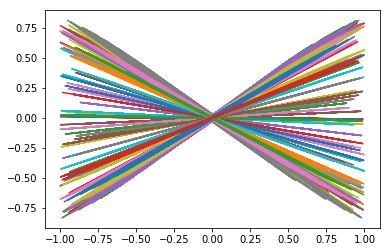

In [3]:
#function data is generated from
def f(x, parameter):
    return np.sin(parameter*x)

num_datapoints = 50
r_size = 2
z_size = 2
parameter_range = (-1, 1)
num_functions = 2000

general_datapoints = []
for i in range(num_functions):
    datapoints = []
    param = np.random.uniform(parameter_range[0], parameter_range[1])
    for i in range(num_datapoints):
        x = np.random.uniform(-1,1)
        datapoints.append([x,f(x, param)])
    datapoints = np.array(datapoints)
    general_datapoints.append(datapoints.copy())

for i in range(64):
    datapoints = general_datapoints[i]
    plt.plot(datapoints[:,0], datapoints[:,1])

In [4]:
class r_encoder(nn.Module):
    def __init__(self):
        super(r_encoder, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, r_size)
        self.relu = nn.ReLU()
        
    def forward(self, z):
        r1 = self.relu(self.fc1(z))
        r2 = self.relu(self.fc2(r1))
        output = self.fc3(r2)
        return output

class z_encoder(nn.Module):
    def __init__(self):
        super(z_encoder, self).__init__()
        self.fc1 = nn.Linear(r_size, 10)
        self.fc2_mu = nn.Linear(10, z_size)
        self.fc2_logvar = nn.Linear(10, z_size)
        self.relu = nn.ReLU()
        
    def forward(self, r):
        r1 = self.relu(self.fc1(r))
        mu = self.fc2_mu(r1)
        logvar = self.fc2_logvar(r1)
        std =  logvar.mul(1/2).exp()
        return mu, std
    
class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()
        self.fc1 = nn.Linear(z_size + 1, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc_mu = nn.Linear(10, 1)
        self.fc_logvar = nn.Linear(10, 1)
        self.relu = nn.ReLU()
        
    def forward(self, z, x):
        zx = torch.cat((z,x))
        r1 = self.relu(self.fc1(zx))
        r2 = self.relu(self.fc2(r1))
        output_mu = self.fc_mu(r2)
        output_logvar = self.fc_logvar(r2)
        std =  output_logvar.mul(1/2).exp()
        return output_mu, std

In [5]:
class neural_process(nn.Module):
    def __init__(self):
        super(neural_process, self).__init__()
        self.r_enc = r_encoder()
        self.z_enc = z_encoder()
        self.dec = decoder()
        
    def xz_to_y(self, x, z):
        x = x.type('torch.FloatTensor')
        z = z.type('torch.FloatTensor')
        return self.dec(z, x)
    
    def xy_to_z(self, x, y):
        avg_r = torch.zeros(r_size)
        for i in range(len(x)):
            avg_r += self.r_enc(torch.tensor([x[i], y[i]]).type('torch.FloatTensor'))
        avg_r = avg_r/len(x)
        return self.z_enc(avg_r)
            
    def forward(self, x_context, y_context, x_target, y_target=None):
        if self.training:
            mu_target, sigma_target = self.xy_to_z(x_target, y_target)
            mu_context, sigma_context = self.xy_to_z(x_context, y_context)
            q_target = torch.distributions.Normal(mu_target, sigma_target)
            q_context = torch.distributions.Normal(mu_context, sigma_context)
            z_sample = q_target.rsample()
            y_pred_mu, y_pred_sigma = self.xz_to_y(x_target, z_sample)
            p_y_pred = torch.distributions.Normal(y_pred_mu, y_pred_sigma)
            return p_y_pred, q_target, q_context
        
        else:
            mu_context, sigma_context = self.xy_to_z(x_context, y_context)
            q_context = torch.distributions.Normal(mu_context, sigma_context)
            z_sample = q_context.rsample()
            y_pred_mu, y_pred_sigma = self.xz_to_y(x_target, z_sample)
            p_y_pred = torch.distributions.Normal(y_pred_mu, y_pred_sigma)
            return p_y_pred
        
    def prior_plot(self, num):
        x_target = torch.tensor(np.linspace(-1, 1, 100))
        for i in range(num):
            mus = []
            z_sample = torch.randn((1, z_size))
            for x in x_target:
                mu, _ = self.xz_to_y(torch.tensor([x]), z_sample[0])
                mus.append(mu.detach().numpy())
                
            plt.plot(x_target.numpy(), mus)
            
model = neural_process()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

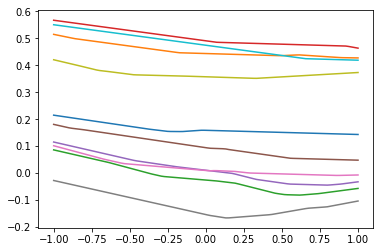

In [6]:
#plots from untrained prior
model.prior_plot(10)

In [7]:
def lossf(p_y_pred, y_target, q_target, q_context):
    log_likelihood = p_y_pred.log_prob(y_target.double()[0]).mean(dim=0).sum()
    kl = torch.distributions.kl.kl_divergence(q_target, q_context).mean(dim=0).sum()
    return -log_likelihood + kl

In [18]:
def train(general_datapoints, epochs):
    model.train()
    for epoch in range(epochs):
        for datapoints in general_datapoints:
            epoch_loss = 0

            randint = np.random.randint(len(datapoints))
            target_data = datapoints[randint]
            x_target = torch.tensor([target_data[0]])
            y_target = torch.tensor([target_data[1]])
            x_context = torch.tensor(datapoints[:,0])
            y_context = torch.tensor(datapoints[:,1])

            optimizer.zero_grad()
            p_y_pred, q_target, q_context = model(x_context, y_context, x_target, y_target)
            loss = lossf(p_y_pred, y_target, q_target, q_context)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
        if epoch % 1 == 0:
            print('EPOCH: {},  EPOCH LOSS: {}'.format(epoch, epoch_loss))
            model.prior_plot(10)

EPOCH: 0,  EPOCH LOSS: 1.9703505039215088
EPOCH: 1,  EPOCH LOSS: 0.9534104466438293
EPOCH: 2,  EPOCH LOSS: 1.7927523851394653
EPOCH: 3,  EPOCH LOSS: -0.028222650289535522
EPOCH: 4,  EPOCH LOSS: 2.386023998260498
EPOCH: 5,  EPOCH LOSS: 0.7661331295967102
EPOCH: 6,  EPOCH LOSS: -0.33975568413734436
EPOCH: 7,  EPOCH LOSS: 0.05950355529785156
EPOCH: 8,  EPOCH LOSS: 1.16473388671875
EPOCH: 9,  EPOCH LOSS: 1.42229163646698
EPOCH: 10,  EPOCH LOSS: -0.79010009765625
EPOCH: 11,  EPOCH LOSS: -0.24510550498962402
EPOCH: 12,  EPOCH LOSS: 3.0588951110839844
EPOCH: 13,  EPOCH LOSS: -0.4616668224334717
EPOCH: 14,  EPOCH LOSS: 0.59868323802948
EPOCH: 15,  EPOCH LOSS: 2.3720993995666504
EPOCH: 16,  EPOCH LOSS: -0.44990766048431396
EPOCH: 17,  EPOCH LOSS: -0.9115564823150635
EPOCH: 18,  EPOCH LOSS: -0.8092978000640869
EPOCH: 19,  EPOCH LOSS: 1.8922088146209717
EPOCH: 20,  EPOCH LOSS: 0.9117646217346191
EPOCH: 21,  EPOCH LOSS: -0.5070474147796631
EPOCH: 22,  EPOCH LOSS: -0.5052838325500488
EPOCH: 23,  EP

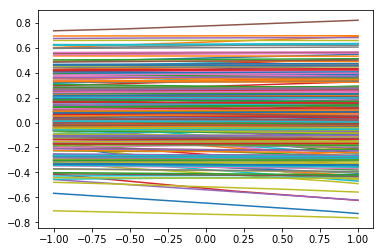

In [19]:
train(general_datapoints, 30)

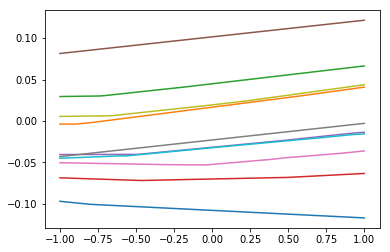

In [14]:
#plots from trained prior
model.prior_plot(10)

In [15]:
def plot(x_context, y_context):
    lin = torch.tensor(np.linspace(-1, 1, 100))
    model.eval()
    ys = []
    uqs = []
    lqs = []
    for x in lin:
        p_y_pred = model(x_context, y_context, torch.tensor([x]))
        y = p_y_pred.mean
        stddev = p_y_pred.stddev
        uqs.append(y + 2*stddev)
        lqs.append(y - 2*stddev)
        ys.append(y.detach().numpy())
    plt.plot(lin.numpy(), ys)
    plt.plot(lin.numpy(), uqs, c = 'grey')
    plt.plot(lin.numpy(), lqs, c = 'grey')
    plt.scatter(x_context, y_context)

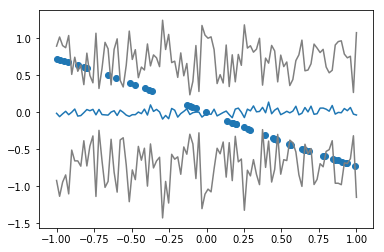

In [16]:
plot(torch.tensor(general_datapoints[1][:,0]), torch.tensor(general_datapoints[1][:,1]))

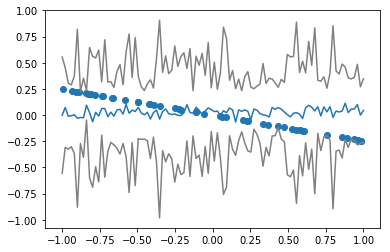

In [17]:
plot(torch.tensor(general_datapoints[99][:,0]), torch.tensor(general_datapoints[99][:,1]))